In [4]:
import pandas as pd

# Load dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Quick overview of data
print(train_df.head())
print(train_df.info())

# Check target distribution
print(train_df['target'].value_counts(normalize=True))


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
target
0    0.57034
1    0.42966
Nam

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function for text cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags but keep the word
    text = re.sub(r'\@\w+|\#', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Apply cleaning function to the text column
train_df['clean_text'] = train_df['text'].apply(clean_text)

# Show cleaned text
print(train_df[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\namis\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\namis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\namis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  13000 people receive wildfire evacuation order...  
4  got sent photo ruby alaska smoke wildfire pour...  


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer with max 10,000 features
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # Includes single words + bigrams

# Transform text data
X_tfidf = tfidf.fit_transform(train_df['clean_text'])
y = train_df['target']

print("TF-IDF Matrix Shape:", X_tfidf.shape)  # Check dimensions


TF-IDF Matrix Shape: (7613, 10000)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['clean_text'])

X_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_padded = pad_sequences(X_seq, maxlen=50, padding='post')
y = train_df['target']

# Define Model with All Fixes
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=50),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.5)),  # Higher dropout
    Bidirectional(LSTM(16, dropout=0.5)),  # Prevent overfitting
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),  # L2 Regularization
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile with Lower Learning Rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Callbacks for Better Generalization
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

# Train Model
history = model.fit(X_padded, y, batch_size=16, epochs=15, validation_split=0.2, callbacks=[early_stopping, reduce_lr])


Epoch 1/15


C:\Users\namis\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


381/381 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.5880 - loss: 0.9002 - val_accuracy: 0.7617 - val_loss: 0.7734 - learning_rate: 5.0000e-04
Epoch 2/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.7847 - loss: 0.6069 - val_accuracy: 0.7919 - val_loss: 0.5773 - learning_rate: 5.0000e-04
Epoch 3/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.8550 - loss: 0.4519 - val_accuracy: 0.7715 - val_loss: 0.5729 - learning_rate: 5.0000e-04
Epoch 4/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8893 - loss: 0.3645 - val_accuracy: 0.7505 - val_loss: 0.6365 - learning_rate: 5.0000e-04
Epoch 5/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9239 - loss: 0.2811 - val_accuracy: 0.7544 - val_loss: 0.6623 - learning_rate: 2.5000e-04
Epoch 6/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9439 - loss: 0.2423 - val_accuracy: 0.7485 - val_loss: 0.6916 - learning_rate: 1.2500e-04


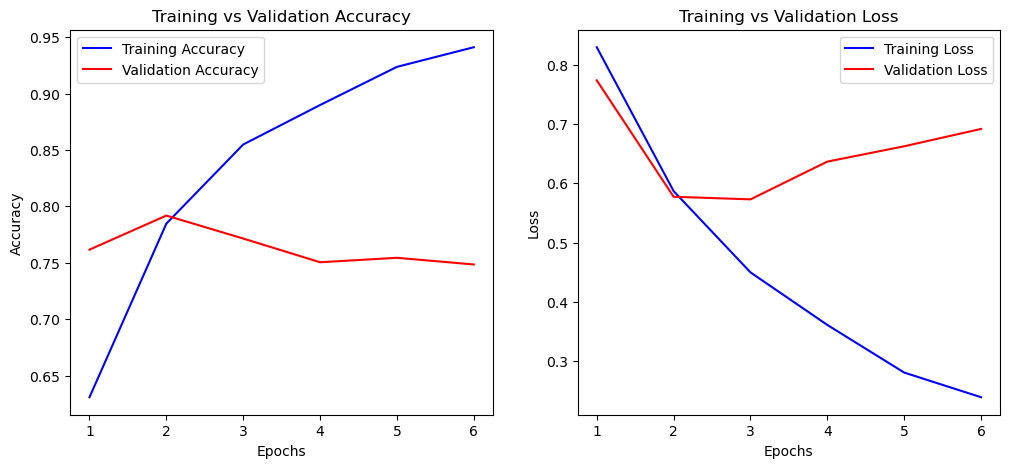

In [16]:
import matplotlib.pyplot as plt

# Extract values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)  # X-axis values

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # First plot
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)  # Second plot
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()